# Credit Card Lead Prediction

**Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.**

The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 

In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.

Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

* Customer details (gender, age, region etc.)
* Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

**Data Dictionary**

* ID = Unique Identifier for a row
* Gender = Gender of the Customer
* Age = Age of the Customer (in Years)
* Region_Code = Code of the Region for the customers
* Occupation = Occupation Type for the customer
* Channel_Code = Acquisition Channel Code for the Customer  (Encoded)
* Vintage = Vintage for the Customer (In Months)
* Credit_Product = If the Customer has any active credit product (Home loan,Personal loan, Credit Card etc.)
* Avg_Account_Balance = Average Account Balance for the Customer in last 12 Months
* Is_Active = If the Customer is Active in last 3 Months
* Is_Lead(Target) = If the Customer is interested for the Credit Card
    * 0 : Customer is not interested
    * 1 : Customer is interested



In [1]:
# importing libraries
from pyforest import *
# seeing all the libraries that were imported
lazy_imports()
import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the train dataset
df = pd.read_csv('/content/drive/MyDrive/CRedit Card Lead Prediction/train.csv')
df.head()

<IPython.core.display.Javascript object>

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


Upon searching what is vintage ? It can be explained as follows:

In credit risk, it is a popular method for managing credit risk. The term 'Vintage' refers to the month or quarter in which account was opened (loan was granted). In simple words, the vintage analysis measures the performance of a portfolio in different periods of time after the loan (or credit card) was granted. Performance can be measured in the form of cumulative charge-off rate, proportion of customers 30/60/90 days past due (DPD), utilization ratio, average balance etc.

The vintage analysis is used for a variety of purposes. Some of them are listed below -
* Identify if accounts opened in a particular month or quarter are riskier than others
* Determine the optimal period of performance window in development of scorecard
* Monitor or track risk of a portfolio
* Estimate minimum months required after that we can cross-sell to new customers
* Forecast risk
* Can be used in stress testing

In [3]:
df.shape

(245725, 11)

In [4]:
df.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

# 1. Analysis

In [5]:
# checking for missing values 
df.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [6]:
# checkuing the percentage of missing data
df.isnull().sum()/len(df)

ID                     0.000000
Gender                 0.000000
Age                    0.000000
Region_Code            0.000000
Occupation             0.000000
Channel_Code           0.000000
Vintage                0.000000
Credit_Product         0.119341
Avg_Account_Balance    0.000000
Is_Active              0.000000
Is_Lead                0.000000
dtype: float64

In [7]:
# dropping those rows in Credit_Product
df.dropna(axis=0, inplace=True)
df.isnull().sum()

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

In [8]:
# checking duplicate values
df.duplicated().sum()

0

In [9]:
# dropping duplicate values
df.drop_duplicates(inplace=True)

In [10]:
# statistical summary of data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,216400.0,4.280732e+01,14.850996,23.0,29.00,41.0,53.0,85.0
Vintage,216400.0,4.428552e+01,31.235351,7.0,20.00,31.0,67.0,135.0
Avg_Account_Balance,216400.0,1.115086e+06,850017.219721,20790.0,595843.75,880539.0,1346543.0,10352009.0
Is_Lead,216400.0,1.539418e-01,0.360894,0.0,0.00,0.0,0.0,1.0


Initial knowledge of data:
* There are 11 features including the target variable.
* Dataset has 24 lakh rows which will be good for machine learning upon dividing into further train and test data set.
* Channel_Code feature is encoded, so what it represents is not known at this point of time.
* There are no outliers w.r.t Age, Vintage, Avg_Account_Balance and the target variable i.e. Is_lead.
* Account_balance seems to be in range of 20k and max is 1 crore.

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Count of customers who can be targeted')

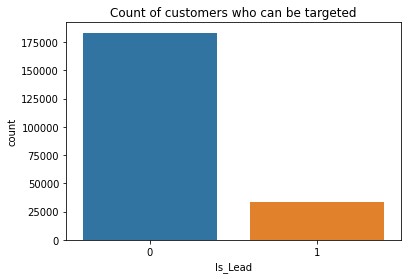

In [11]:
# exploring target variable 
sns.countplot(df['Is_Lead']).set_title('Count of customers who can be targeted')

In [12]:
per_0 = len(df[df['Is_Lead'] == 0]) / len(df)
per_1 = len(df[df['Is_Lead'] == 1]) / len(df)

print('Percentage of possible target customers is {:.2f}'.format(per_1))

Percentage of possible target customers is 0.15


* Target variable is not properly distributed as it can be seen that not potentail target customers are near 75%, therefore while splitting data this has to be considered, so that the model does not overfit with non potential customers.

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Gender distribution')

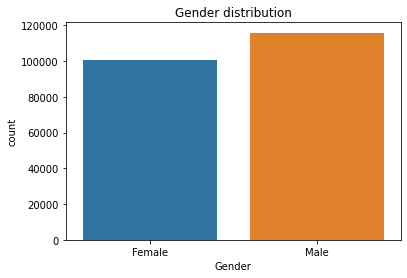

In [13]:
# considering gender variable and its relation with target variable 
sns.countplot(df['Gender']).set_title('Gender distribution')

In [14]:
df['Gender'].value_counts()

Male      115919
Female    100481
Name: Gender, dtype: int64

In [15]:
# gender percentage in data
df['Gender'].value_counts() / len(df)

Male      0.53567
Female    0.46433
Name: Gender, dtype: float64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Potenitial customers across different gender')

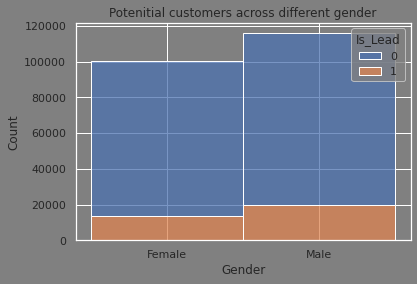

In [16]:
sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey'})
sns.histplot(binwidth=0.5, x="Gender", hue="Is_Lead", data=df, stat="count", multiple="stack")
plt.title('Potenitial customers across different gender')

* Male and Female are fairly distributed but males having higher representation around 10% than females and so is the case when it comes to becoming potential target customers to sell credit cards.

In [17]:
df['Age'].describe()

count    216400.000000
mean         42.807315
std          14.850996
min          23.000000
25%          29.000000
50%          41.000000
75%          53.000000
max          85.000000
Name: Age, dtype: float64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Age distribution')

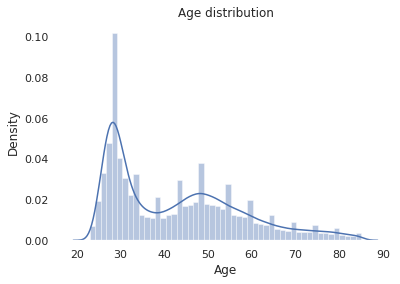

In [18]:
# exploring age
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.distplot(df['Age']).set_title('Age distribution')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Box Plot \n Potential vs non-potential across age')

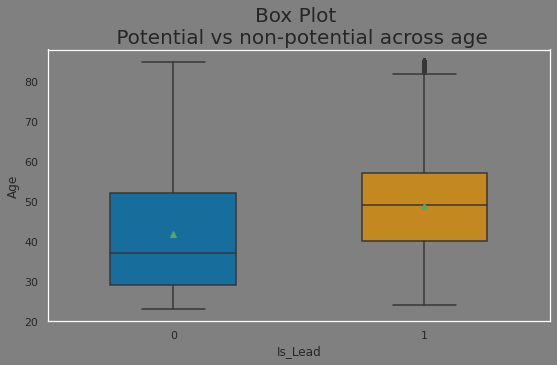

In [19]:
sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey', 'axes.grid':False})
plt.figure(figsize=(9,5))
boxplot = sns.boxplot(
    x = 'Is_Lead',
    y='Age',
    data=df, showmeans=True,
    width=0.5, 
    palette="colorblind")
plt.title("Box Plot \n Potential vs non-potential across age", fontsize=20)

* Majority of customers are in their late 20's and early 30's, but according to statistical summary from above average is 43. 
* Age distribution is positively skewed as it can be said that as the age increases the customers in that age ratio in population decreases and therefore can be seen that customers who are 60 and plus are in very low ratio in the dataset.
* Age group betwen 40 to 60 are likely to be more potential customers.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text major ticklabel objects>)

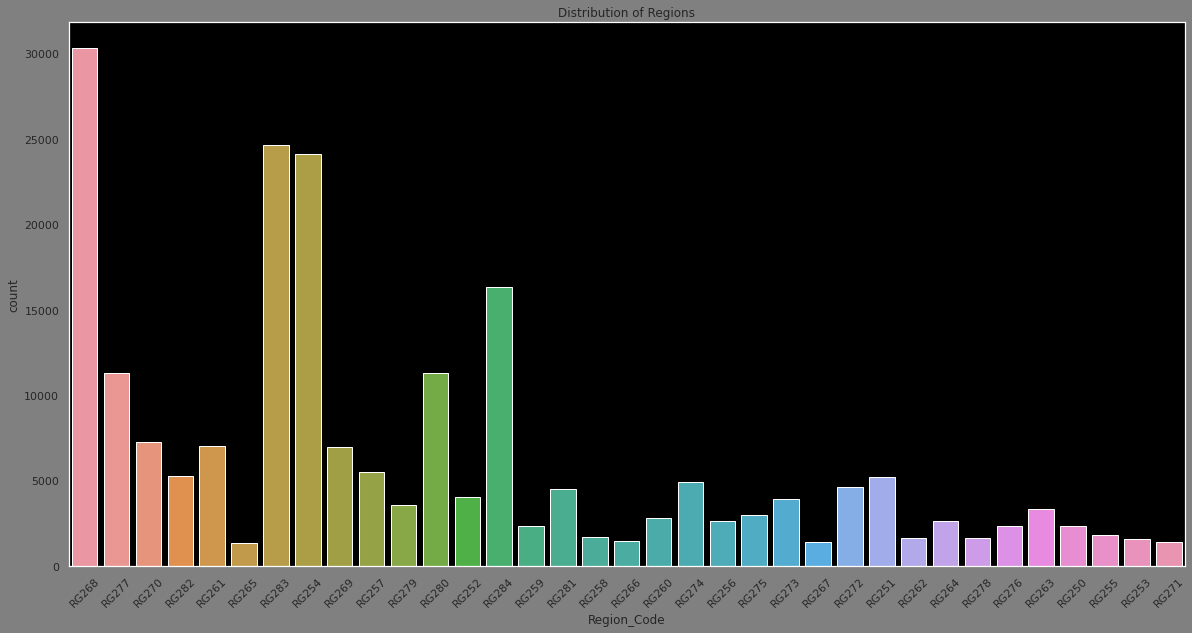

In [20]:
# region code column 
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'grey', 'axes.grid':False})
plt.figure(figsize=(20,10))
sns.countplot(df['Region_Code']).set_title('Distribution of Regions')
plt.xticks(rotation=45)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Potenitial customers across different regions')

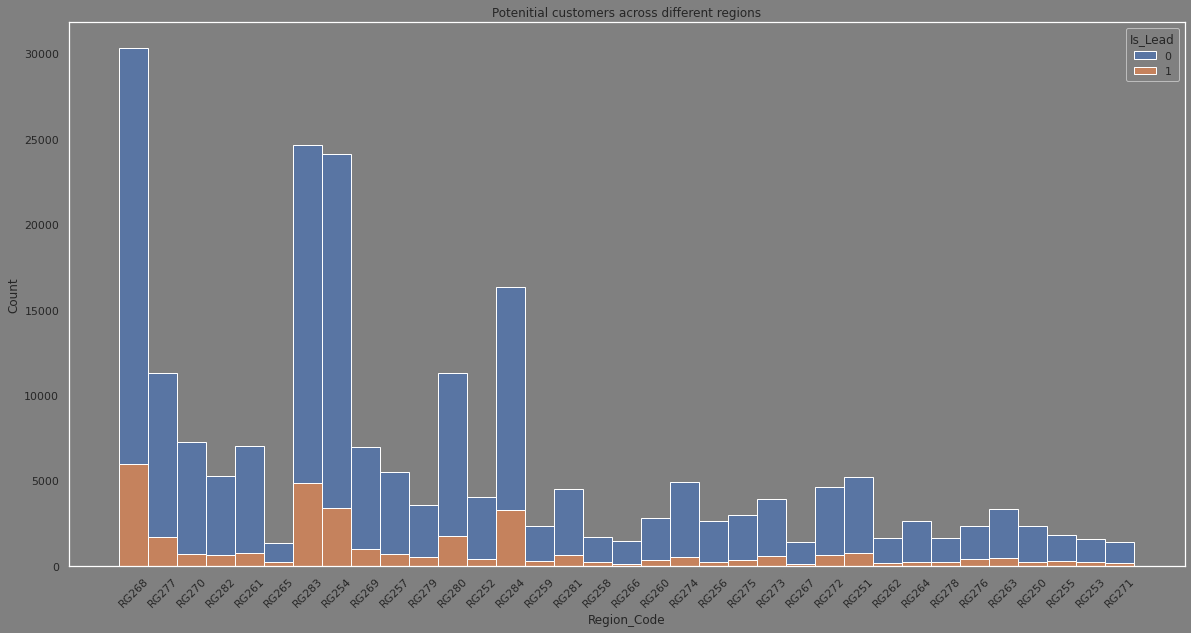

In [21]:
sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey', 'axes.grid' : False})
plt.figure(figsize=(20,10))
sns.histplot(binwidth=0.5, x="Region_Code", hue="Is_Lead", data=df, stat="count", multiple="stack")
plt.xticks(rotation=45)
plt.title('Potenitial customers across different regions')

* This Region variable is highly represented by three to four regions as compared to others, so for in model training this could lead to some biasness. In order to reduce biuasnes, can implement the rare label encoding.

* Also the areas which are more represented have less number of potential customers which can be targeted.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

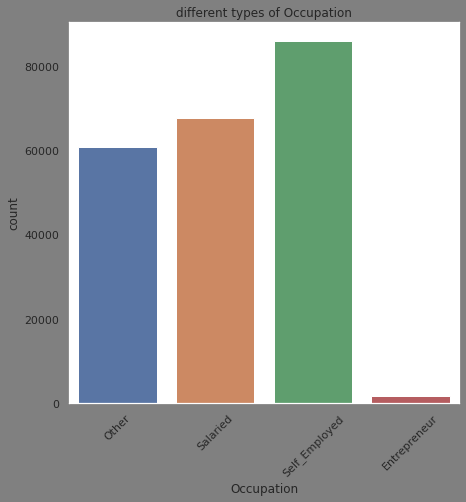

In [22]:
# Occupation column 
plt.figure(figsize=(7,7))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.countplot(df['Occupation']).set_title('different types of Occupation')
plt.xticks(rotation=45)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

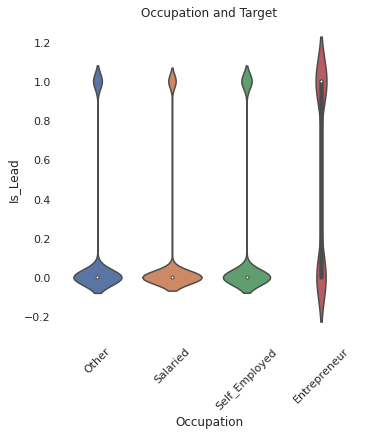

In [23]:
sns.catplot(x="Occupation",
                y = 'Is_Lead',
                kind="violin",
                data=df)
plt.title('Occupation and Target')
plt.xticks(rotation=45)

* Entrepreneurs are less represented compared to other three catogories, though they are more likely to buy credit cards.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'different types of Channels')

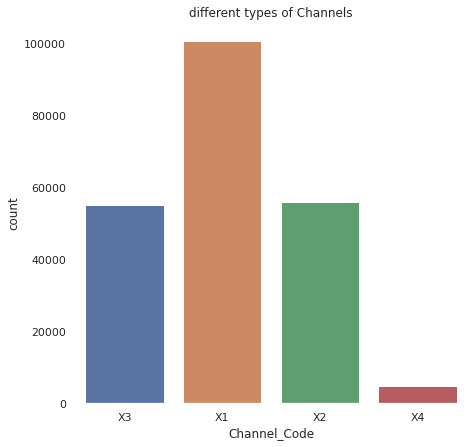

In [24]:
# channel column 
plt.figure(figsize=(7,7))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.countplot(df['Channel_Code']).set_title('different types of Channels')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Channel_COde and Target')

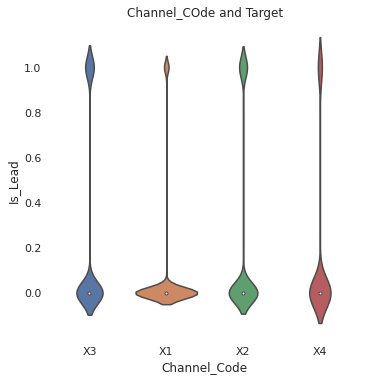

In [25]:
sns.catplot(x="Channel_Code",
                y = 'Is_Lead',
                kind="violin",
                data=df)
plt.title('Channel_COde and Target')

* What is this channel_code is not known as its encode, but from the above plots it seems like customers from chnnel x1 are very less likely to be the potential target customers for credit cards.
* channel x4 is not represented well compared to other categories.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Vintage distribution')

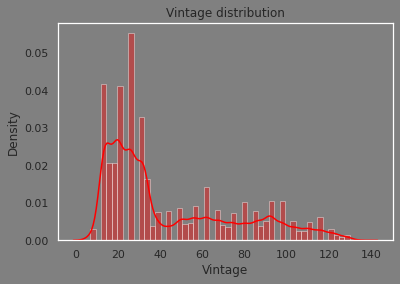

In [26]:
# vintasge column 
sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey', 'axes.grid':False})
sns.distplot(df['Vintage'], color='red').set_title('Vintage distribution')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Age distribution')

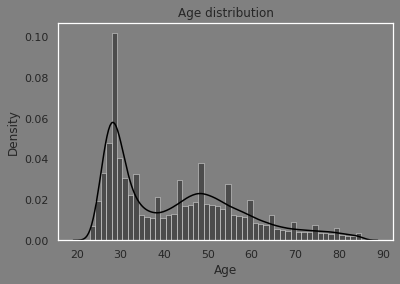

In [27]:
sns.distplot(df['Age'], color='black').set_title('Age distribution')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Box Plot \n Potential vs non-potential with Vintage')

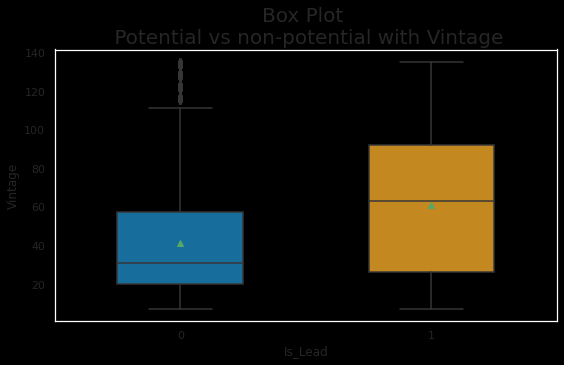

In [28]:
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid':False})
plt.figure(figsize=(9,5))
boxplot = sns.boxplot(
    x = 'Is_Lead',
    y='Vintage',
    data=df, showmeans=True,
    width=0.5, 
    palette="colorblind")
plt.title("Box Plot \n Potential vs non-potential with Vintage", fontsize=20)

* From the above two plots its clear that Vintagee closely follows the trend of age of customers.
* From what we know of VIntage it can inferenced that with age in the range of 20'sa to 30's the credit risk is high and in the age group of 40's to 60's its low.
* Seems like any whose Vintage months are in the range of 30 to 90 can be good targets for credit cards. 

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Customers owning credit products')

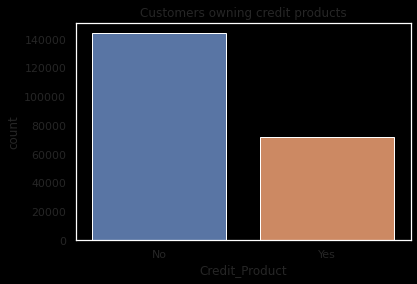

In [29]:
# credit_products
sns.countplot(df['Credit_Product']).set_title('Customers owning credit products')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Potenitial customers owning credit products')

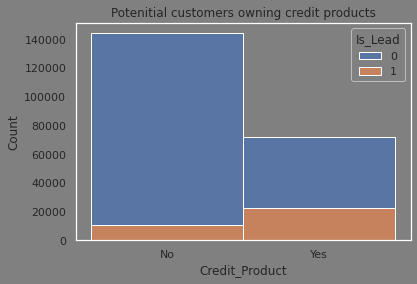

In [30]:
sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey', 'axes.grid' : False})
sns.histplot(binwidth=0.5, x="Credit_Product", hue="Is_Lead", data=df, stat="count", multiple="stack")
plt.title('Potenitial customers owning credit products')

* Customers having credit products are less and also it should be noted that around 12% of the data is missing for this column. ALso it can be noted, that those already owning are more potential customers.

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Account balance distribution')

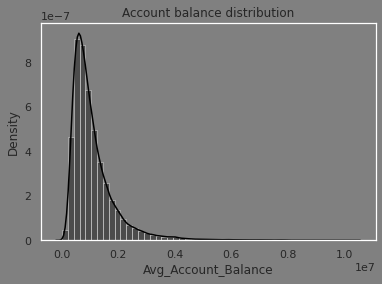

In [31]:
# balance 
sns.distplot(df['Avg_Account_Balance'], color='black').set_title('Account balance distribution')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Box Plot \n Potential vs non-potential across balance')

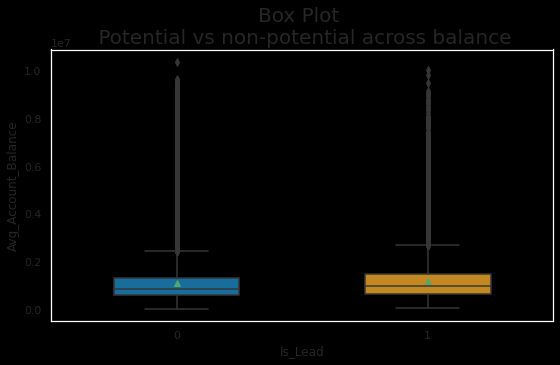

In [32]:
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid':False})
plt.figure(figsize=(9,5))
boxplot = sns.boxplot(
    x = 'Is_Lead',
    y='Avg_Account_Balance',
    data=df, showmeans=True,
    width=0.5, 
    palette="colorblind")
plt.title("Box Plot \n Potential vs non-potential across balance", fontsize=20)

* Balance is positively skewed. Seems like any whose account balance is low are potential customers.


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Customers whether they are acitve or not')

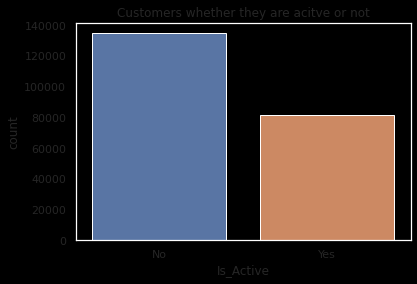

In [33]:
# active customers
sns.countplot(df['Is_Active']).set_title('Customers whether they are acitve or not')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Potenitial customers who are active')

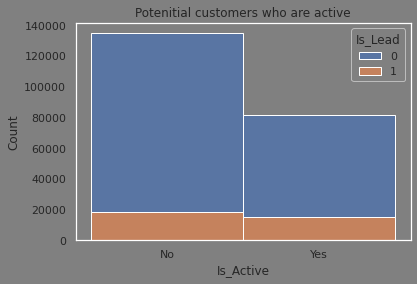

In [34]:
sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey', 'axes.grid' : False})
sns.histplot(binwidth=0.5, x="Is_Active", hue="Is_Lead", data=df, stat="count", multiple="stack")
plt.title('Potenitial customers who are active')

* there are lots of non-active customers and can be of more potential customers

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text major ticklabel objects>)

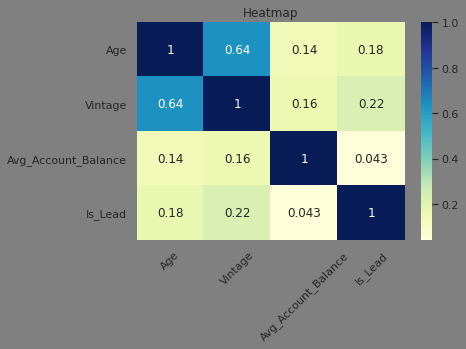

In [35]:
# heatmap for continuous variables 
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'grey'})
sns.heatmap(df.corr(), annot=True, cbar=True, cmap="YlGnBu").set_title('Heatmap')
plt.xticks(rotation=45)

* As deduced earlier, age and vintage are positively correlated with each other.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

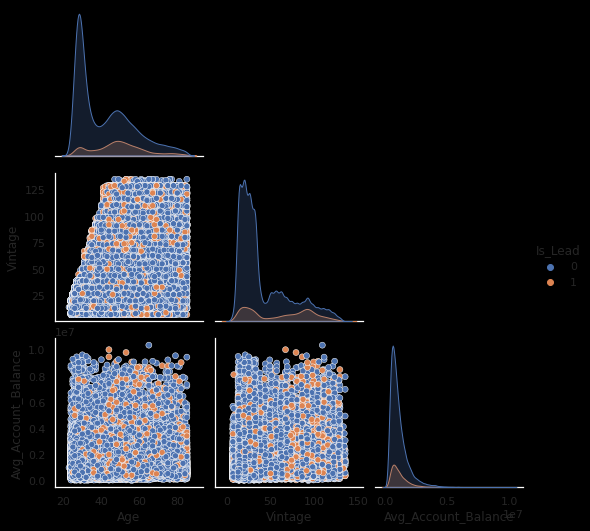

In [36]:
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid':False})
sns.pairplot(df, corner=True, hue='Is_Lead')

# 2. Feature Engineering

In [37]:
# dropping ID column as it would be unique for each customer and it would give no further knowledge to ML
df.drop(['ID'], axis=1, inplace=True)
df.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [38]:
# seperating independent and dependent features
x = df.iloc[:, :-1]
y = df['Is_Lead']
x.shape, y.shape

((216400, 9), (216400,))

In [39]:
test = pd.read_csv('/content/drive/MyDrive/CRedit Card Lead Prediction/test.csv')
test.head()

<IPython.core.display.Javascript object>

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [40]:
test.shape

(105312, 10)

In [41]:
# checking for null values
test.isnull().sum() / len(test)

ID                     0.000000
Gender                 0.000000
Age                    0.000000
Region_Code            0.000000
Occupation             0.000000
Channel_Code           0.000000
Vintage                0.000000
Credit_Product         0.118904
Avg_Account_Balance    0.000000
Is_Active              0.000000
dtype: float64

In [42]:
test.duplicated().sum()

0

<IPython.core.display.Javascript object>

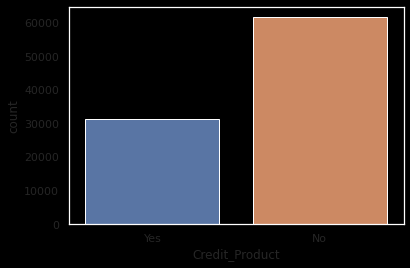

In [43]:
sns.countplot(test['Credit_Product'])

In [44]:
# # dropping those rows in Credit_Product
# test.dropna(axis=0, inplace=True)

# filling the missing values with less frequent category 
test['Credit_Product'].fillna(test['Credit_Product'].mode()[0], inplace=True)
test.isnull().sum()

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
dtype: int64

In [45]:
# dropping ID column as it would be unique for each customer and it would give no further knowledge to ML
test.drop(['ID'], axis=1, inplace=True)
test.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,Male,29,RG254,Other,X1,25,Yes,742366,No
1,Male,43,RG268,Other,X2,49,No,925537,No
2,Male,31,RG270,Salaried,X1,14,No,215949,No
3,Male,29,RG272,Other,X1,33,No,868070,No
4,Female,29,RG270,Other,X1,19,No,657087,No


In [46]:
# label encoding gender, credit_product and is_Active
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# le.fit(df['Gender'])
# le.fit(df['Credit_Product'])
# le.fit(df['Is_Active'])


x['Gender'] = le.fit_transform(x['Gender'])
x['Credit_Product'] = le.fit_transform(x['Credit_Product'])
x['Is_Active'] = le.fit_transform(x['Is_Active'])
x['Region_Code'] = le.fit_transform(x['Region_Code'])
x['Occupation'] = le.fit_transform(x['Occupation'])
x['Channel_Code'] = le.fit_transform(x['Channel_Code'])


x.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,0,73,18,1,2,43,0,1045696,0
1,0,30,27,2,0,32,0,581988,0
2,0,56,18,3,2,26,0,1484315,1
3,1,34,20,2,0,19,0,470454,0
4,0,30,32,2,0,33,0,886787,0


In [47]:
# test data
# test = new_test.copy()
test['Gender'] = le.fit_transform(test['Gender'])
test['Credit_Product'] = le.fit_transform(test['Credit_Product'])
test['Is_Active'] = le.fit_transform(test['Is_Active'])
test['Region_Code'] = le.fit_transform(test['Region_Code'])
test['Occupation'] = le.fit_transform(test['Occupation'])
test['Channel_Code'] = le.fit_transform(test['Channel_Code'])

test.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,1,29,4,1,0,25,1,742366,0
1,1,43,18,1,1,49,0,925537,0
2,1,31,20,2,0,14,0,215949,0
3,1,29,22,1,0,33,0,868070,0
4,0,29,20,1,0,19,0,657087,0


In [48]:
x.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,216400.0,5.356701e-01,0.498727,0.0,0.00,1.0,1.0,1.0
Age,216400.0,4.280732e+01,14.850996,23.0,29.00,41.0,53.0,85.0
Region_Code,216400.0,1.966927e+01,10.874542,0.0,10.00,19.0,30.0,34.0
Occupation,216400.0,2.101534e+00,0.836273,0.0,1.00,2.0,3.0,3.0
Channel_Code,216400.0,8.338309e-01,0.883962,0.0,0.00,1.0,2.0,3.0
Vintage,216400.0,4.428552e+01,31.235351,7.0,20.00,31.0,67.0,135.0
Credit_Product,216400.0,3.329159e-01,0.471258,0.0,0.00,0.0,1.0,1.0
Avg_Account_Balance,216400.0,1.115086e+06,850017.219721,20790.0,595843.75,880539.0,1346543.0,10352009.0
Is_Active,216400.0,3.767745e-01,0.484579,0.0,0.00,0.0,1.0,1.0


# 3. Feature selection

In [49]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=4)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((162300, 9), (54100, 9), (162300,), (54100,))

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline

from feature_engine.selection import (
    RecursiveFeatureAddition,
    DropConstantFeatures,
    DropDuplicateFeatures,
)


pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(x_train)

# remove features

x_train = pipe.transform(x_train)
x_test = pipe.transform(x_test)
test = pipe.transform(test)

x_train.shape, x_test.shape, test.shape

((162300, 9), (54100, 9), (105312, 9))

In [51]:
# the ML model for which we want to select features

model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=4,
    random_state=4,
)

In [52]:
# Setup the RFA selector

rfa = RecursiveFeatureAddition(
    variables=None,  # automatically evaluate all numerical variables
    estimator=model,  # the ML model
    scoring='roc_auc',  # the metric we want to evalute
    threshold=0.0001,  # the minimum performance increase needed to select a feature
    cv=2,  # cross-validation
)

rfa.fit(x_train, y_train)

RecursiveFeatureAddition(cv=2,
                         estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                              criterion='friedman_mse',
                                                              init=None,
                                                              learning_rate=0.1,
                                                              loss='deviance',
                                                              max_depth=4,
                                                              max_features=None,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_

In [53]:
# performance of model trained using all features

rfa.initial_model_performance_

0.791051667346748

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

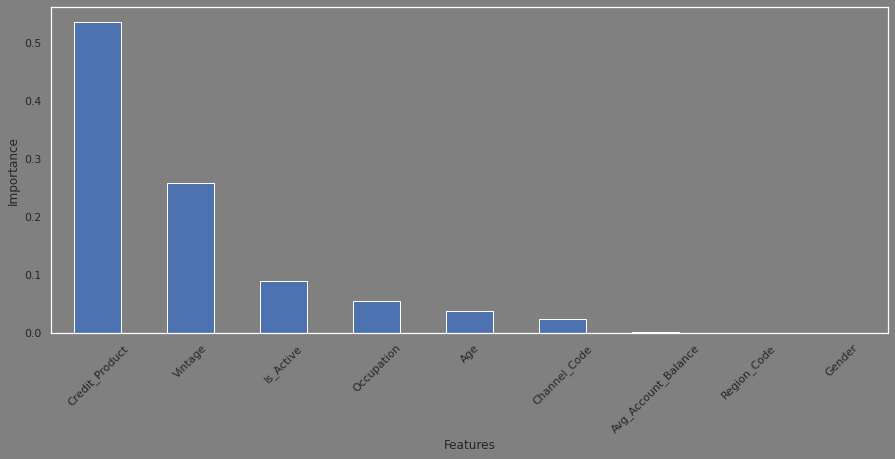

In [54]:
# importance of all features based of initial model
sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'grey', 'axes.grid':False})
rfa.feature_importances_.plot.bar(figsize=(15,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

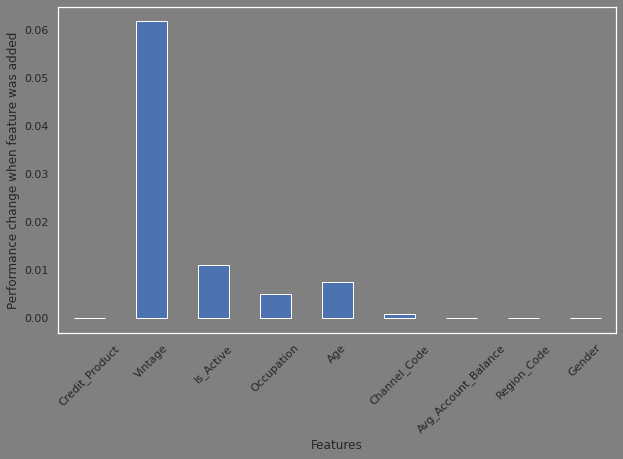

In [55]:
pd.Series(rfa.performance_drifts_).plot.bar(figsize=(10,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.xticks(rotation=45)
plt.show()

In [56]:
# Number of features that will be removed

len(rfa.features_to_drop_)

3

In [57]:
# select features

x_train = rfa.transform(x_train)
x_test = rfa.transform(x_test)
test = rfa.transform(test)

In [58]:
# Scaling the data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
test = sc.transform(test)

# 4. Various Model Building

## a. Logistic regression

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
# pr curve and pr auc 
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


In [60]:
logreg = LogisticRegression()

logreg.fit(x_train, y_train)

accuracies = cross_val_score(estimator=logreg, X=x_test, y=y_test)
# determines the cross validation splitting strategy (default is 5 folds)

print('Accuracies: \n', accuracies)

pred = logreg.predict(x_test)

print('\n Mean accuracy: ', accuracies.mean())

Accuracies: 
 [0.84695009 0.84630314 0.84972274 0.84907579 0.84713494]

 Mean accuracy:  0.8478373382624769


In [61]:
accuracy_score(y_test, pred)

0.8474861367837339

### hyper parameter logistic

In [62]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

clf = GridSearchCV(logreg, param_grid=param_grid, cv=3, verbose=True, n_jobs=-1)

best_clf = clf.fit(x_train, y_train)

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 514 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 908 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2030 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 2694 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 3486 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 4406 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 22.3min finished


In [63]:
best_clf.best_estimator_

LogisticRegression(C=0.012742749857031334, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
logr = LogisticRegression(C=0.0018329807108324356, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

logr.fit(x_train, y_train)

accuracies = cross_val_score(estimator=logr, X=x_test, y=y_test)
# determines the cross validation splitting strategy (default is 5 folds)

print('Accuracies: \n', accuracies)

pred = logr.predict(x_test)

print('\n Mean accuracy: ', accuracies.mean())

Accuracies: 
 [0.84685767 0.84537893 0.84879852 0.84842884 0.84750462]

 Mean accuracy:  0.8473937153419593


Confusion Matrix for logistic regression


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

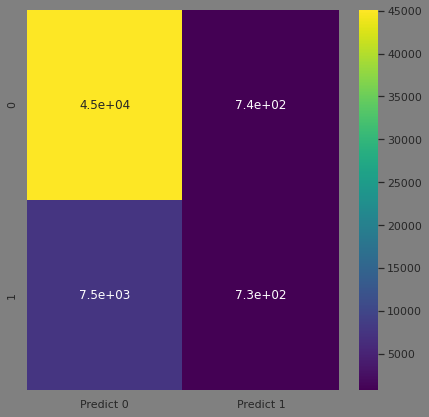

In [65]:
print('Confusion Matrix for logistic regression')

cm = metrics.confusion_matrix(y_test, pred, labels=[0,1])

df_cm = pd.DataFrame(cm, index=[i for i in [0,1]],
                     columns=[i for i in ['Predict 0', 'Predict 1']])

plt.figure(figsize=(7,7))

sns.heatmap(df_cm, annot=True, cmap='viridis')

In [66]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     45845
           1       0.50      0.09      0.15      8255

    accuracy                           0.85     54100
   macro avg       0.68      0.54      0.53     54100
weighted avg       0.80      0.85      0.80     54100



In [67]:
df_cm

,Predict 0,Predict 1
0,45108,737
1,7524,731


Logistic ROC AUC: 0.768


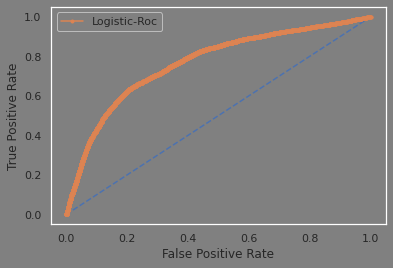

In [68]:
from matplotlib import pyplot

yhat = logr.predict_proba(x_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='Logistic-Roc')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
print('Logistic ROC AUC: %.3f' % roc_auc_score(y_test, pos_probs))
# show the plot
pyplot.show()

In [69]:
# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs):
	# calculate the no skill line as the proportion of the positive class
	no_skill = len(test_y[test_y==1]) / len(test_y)
	# plot the no skill precision-recall curve
	pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--')
	# plot model precision-recall curve
	precision, recall, _ = precision_recall_curve(test_y, model_probs)
	pyplot.plot(recall, precision, marker='.', label='Logistic')
	# axis labels
	pyplot.xlabel('Recall')
	pyplot.ylabel('Precision')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()

Logistic PR AUC: 0.377


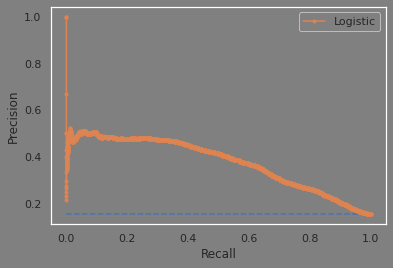

In [70]:
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('Logistic PR AUC: %.3f' % auc_score)
# plot precision-recall curves
plot_pr_curve(y_test, pos_probs)

In [71]:
test_pred = logr.predict(test)
test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [72]:
sub = pd.read_csv('/content/drive/MyDrive/CRedit Card Lead Prediction/test.csv')
output = pd.DataFrame({'ID': sub.ID,
                      'Is_Lead': test_pred})
output.to_csv('/content/drive/MyDrive/CRedit Card Lead Prediction/submission.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## b. XGB

In [73]:
from xgboost import XGBClassifier

xg = XGBClassifier()

xg.fit(x_train, y_train)

xg_accuracies = cross_val_score(xg, X=x_test, y=y_test, cv=10)

print('Accuracies" \n', xg_accuracies)
print()
print('Mean Accuracy: ', xg_accuracies.mean())

Accuracies" 
 [0.86321627 0.86580407 0.85933457 0.86173752 0.86229205 0.86155268
 0.86377079 0.86469501 0.86691312 0.85859519]

Mean Accuracy:  0.8627911275415897


In [74]:
xg_pred = xg.predict(x_test)

accuracy_score(y_test, xg_pred)

0.8630683918669131

Confusion Matrix for logistic regression


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

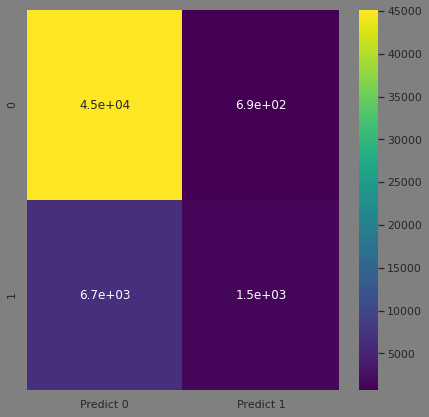

In [75]:
print('Confusion Matrix for logistic regression')

cm = metrics.confusion_matrix(y_test, xg_pred, labels=[0,1])

df_cm = pd.DataFrame(cm, index=[i for i in [0,1]],
                     columns=[i for i in ['Predict 0', 'Predict 1']])

plt.figure(figsize=(7,7))

sns.heatmap(df_cm, annot=True, cmap='viridis')

In [76]:
df_cm

,Predict 0,Predict 1
0,45152,693
1,6715,1540


In [77]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     45845
           1       0.69      0.19      0.29      8255

    accuracy                           0.86     54100
   macro avg       0.78      0.59      0.61     54100
weighted avg       0.84      0.86      0.83     54100



XGB ROC AUC: 0.800


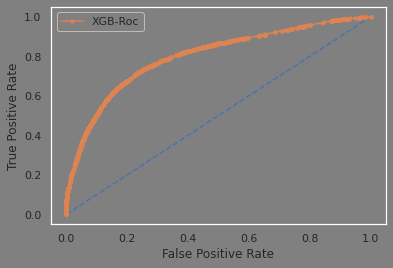

In [78]:
from matplotlib import pyplot

yhat = xg.predict_proba(x_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='XGB-Roc')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
print('XGB ROC AUC: %.3f' % roc_auc_score(y_test, pos_probs))
pyplot.show()

XGB PR AUC: 0.503


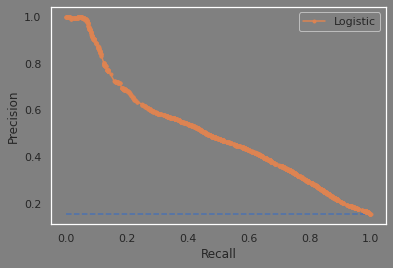

In [79]:
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('XGB PR AUC: %.3f' % auc_score)
# plot precision-recall curves
plot_pr_curve(y_test, pos_probs)

**Hyper parameter tuning**

HYPEROPT is a powerful python library that search through an hyperparameter space of values and find the best possible values that yield the minimum of the loss function.

Bayesian Optimization technique uses Hyperopt to tune the model hyperparameters. Hyperopt is a Python library which is used to tune model hyperparameters.

More information on Hyperopt can be found at the following link:-

https://hyperopt.github.io/hyperopt/?source=post_page

The optimization process consists of 4 parts which are as follows-

1. Initialize domain space
The domain space is the input values over which we want to search.

2. Define objective function
The objective function can be any function which returns a real value that we want to minimize. In this case, we want to minimize the validation error of a machine learning model with respect to the hyperparameters. If the real value is accuracy, then we want to maximize it. Then the function should return the negative of that metric.

3. Optimization algorithm
It is the method used to construct the surrogate objective function and choose the next values to evaluate.

4. Results
Results are score or value pairs that the algorithm uses to build the model.

The available hyperopt optimization algorithms are -

hp.choice(label, options) — Returns one of the options, which should be a list or tuple.

hp.randint(label, upper) — Returns a random integer between the range [0, upper).

hp.uniform(label, low, high) — Returns a value uniformly between low and high.

hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.

hp.normal(label, mean, std) — Returns a real value that’s normally-distributed with mean and standard deviation sigma.

Here best_hyperparams gives us the optimal parameters that best fit model and better loss function value.

trials is an object that contains or stores all the relevant information such as hyperparameter, loss-functions for each set of parameters that the model has been trained.

‘fmin’ is an optimization function that minimizes the loss function and takes in 4 inputs - fn, space, algo and max_evals.

Algorithm used is tpe.suggest.

In [80]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):

    xgbc = xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(x_train, y_train), (x_test, y_test)]
    
    xgbc.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = xgbc.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
  1%|          | 1/100 [00:02<03:55,  2.38s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
  2%|▏         | 2/100 [00:04<03:53,  2.39s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
  3%|▎         | 3/100 [00:07<03:54,  2.42s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
  4%|▍         | 4/100 [00:09<03:49,  2.39s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
  5%|▌         | 5/100 [00:11<03:44,  2.36s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
  6%|▌         | 6/100 [00:14<03:41,  2.36s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
  7%|▋         | 7/100 [00:16<03:39,  2.36s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
  8%|▊         | 8/100 [00:18<03:35,  2.35s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
  9%|▉         | 9/100 [00:21<03:32,  2.34s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 10%|█         | 10/100 [00:23<03:29,  2.32s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 11%|█         | 11/100 [00:25<03:28,  2.34s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 12%|█▏        | 12/100 [00:28<03:24,  2.33s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 13%|█▎        | 13/100 [00:30<03:20,  2.31s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 14%|█▍        | 14/100 [00:32<03:19,  2.32s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 15%|█▌        | 15/100 [00:35<03:18,  2.33s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 16%|█▌        | 16/100 [00:37<03:19,  2.37s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 17%|█▋        | 17/100 [00:40<03:17,  2.38s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 18%|█▊        | 18/100 [00:42<03:15,  2.39s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 19%|█▉        | 19/100 [00:44<03:17,  2.43s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 20%|██        | 20/100 [00:47<03:13,  2.42s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 21%|██        | 21/100 [00:49<03:08,  2.39s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 22%|██▏       | 22/100 [00:52<03:06,  2.39s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 23%|██▎       | 23/100 [00:54<03:02,  2.37s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 24%|██▍       | 24/100 [00:56<02:58,  2.35s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 25%|██▌       | 25/100 [00:59<02:55,  2.34s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 26%|██▌       | 26/100 [01:01<02:52,  2.33s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 27%|██▋       | 27/100 [01:03<02:48,  2.31s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 28%|██▊       | 28/100 [01:05<02:46,  2.31s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 29%|██▉       | 29/100 [01:08<02:45,  2.32s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 30%|███       | 30/100 [01:10<02:42,  2.33s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 31%|███       | 31/100 [01:12<02:40,  2.33s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 32%|███▏      | 32/100 [01:15<02:38,  2.32s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 33%|███▎      | 33/100 [01:17<02:37,  2.35s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 34%|███▍      | 34/100 [01:20<02:36,  2.37s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 35%|███▌      | 35/100 [01:22<02:34,  2.38s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 36%|███▌      | 36/100 [01:24<02:31,  2.37s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 37%|███▋      | 37/100 [01:27<02:30,  2.38s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 38%|███▊      | 38/100 [01:29<02:26,  2.36s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 39%|███▉      | 39/100 [01:31<02:23,  2.36s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 40%|████      | 40/100 [01:34<02:21,  2.36s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 41%|████      | 41/100 [01:36<02:19,  2.37s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 42%|████▏     | 42/100 [01:38<02:16,  2.36s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 43%|████▎     | 43/100 [01:41<02:14,  2.35s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 44%|████▍     | 44/100 [01:43<02:13,  2.39s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 45%|████▌     | 45/100 [01:46<02:11,  2.39s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 46%|████▌     | 46/100 [01:48<02:10,  2.41s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 47%|████▋     | 47/100 [01:51<02:08,  2.43s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 48%|████▊     | 48/100 [01:53<02:06,  2.44s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 49%|████▉     | 49/100 [01:56<02:04,  2.44s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 50%|█████     | 50/100 [01:58<02:00,  2.42s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 51%|█████     | 51/100 [02:00<01:57,  2.40s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 52%|█████▏    | 52/100 [02:03<01:53,  2.37s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 53%|█████▎    | 53/100 [02:05<01:50,  2.36s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 54%|█████▍    | 54/100 [02:07<01:47,  2.34s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 55%|█████▌    | 55/100 [02:10<01:45,  2.34s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 56%|█████▌    | 56/100 [02:12<01:42,  2.33s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 57%|█████▋    | 57/100 [02:14<01:40,  2.35s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 58%|█████▊    | 58/100 [02:17<01:38,  2.34s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 59%|█████▉    | 59/100 [02:19<01:38,  2.40s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 60%|██████    | 60/100 [02:22<01:37,  2.43s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 61%|██████    | 61/100 [02:24<01:35,  2.46s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 62%|██████▏   | 62/100 [02:27<01:33,  2.46s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 63%|██████▎   | 63/100 [02:29<01:30,  2.45s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 64%|██████▍   | 64/100 [02:31<01:28,  2.46s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 65%|██████▌   | 65/100 [02:34<01:24,  2.43s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 66%|██████▌   | 66/100 [02:36<01:22,  2.41s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 67%|██████▋   | 67/100 [02:39<01:19,  2.41s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 68%|██████▊   | 68/100 [02:41<01:18,  2.44s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 69%|██████▉   | 69/100 [02:43<01:14,  2.41s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 70%|███████   | 70/100 [02:46<01:12,  2.43s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 71%|███████   | 71/100 [02:48<01:09,  2.40s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 72%|███████▏  | 72/100 [02:51<01:07,  2.41s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 73%|███████▎  | 73/100 [02:53<01:04,  2.41s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 74%|███████▍  | 74/100 [02:56<01:02,  2.41s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 75%|███████▌  | 75/100 [02:58<00:59,  2.39s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 76%|███████▌  | 76/100 [03:00<00:57,  2.38s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 77%|███████▋  | 77/100 [03:03<00:55,  2.40s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 78%|███████▊  | 78/100 [03:05<00:52,  2.37s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 79%|███████▉  | 79/100 [03:07<00:49,  2.38s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 80%|████████  | 80/100 [03:10<00:48,  2.40s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 81%|████████  | 81/100 [03:12<00:45,  2.39s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 82%|████████▏ | 82/100 [03:15<00:43,  2.40s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 83%|████████▎ | 83/100 [03:17<00:40,  2.38s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 84%|████████▍ | 84/100 [03:19<00:37,  2.37s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 85%|████████▌ | 85/100 [03:22<00:35,  2.37s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 86%|████████▌ | 86/100 [03:24<00:33,  2.39s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 87%|████████▋ | 87/100 [03:27<00:31,  2.42s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 88%|████████▊ | 88/100 [03:29<00:28,  2.41s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 89%|████████▉ | 89/100 [03:31<00:26,  2.43s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 90%|█████████ | 90/100 [03:34<00:24,  2.44s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 91%|█████████ | 91/100 [03:36<00:22,  2.45s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 92%|█████████▏| 92/100 [03:39<00:19,  2.43s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 93%|█████████▎| 93/100 [03:41<00:16,  2.40s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 94%|█████████▍| 94/100 [03:43<00:14,  2.38s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 95%|█████████▌| 95/100 [03:46<00:12,  2.41s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 96%|█████████▌| 96/100 [03:48<00:09,  2.38s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 97%|█████████▋| 97/100 [03:51<00:07,  2.38s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 98%|█████████▊| 98/100 [03:53<00:04,  2.37s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
 99%|█████████▉| 99/100 [03:55<00:02,  2.38s/it, best loss: -0.8474121996303142]

<IPython.core.display.Javascript object>

SCORE:
0.8474121996303142
100%|██████████| 100/100 [03:58<00:00,  2.38s/it, best loss: -0.8474121996303142]


In [81]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5510829918360439, 'gamma': 7.762239614303973, 'max_depth': 9.0, 'min_child_weight': 6.0, 'reg_alpha': 137.0, 'reg_lambda': 0.8205275248072174}


In [95]:
xgbc = XGBClassifier(
    colsample_bytree = 0.5510829918360439, 
    gamma = 7.762239614303973, 
    max_depth = 9, 
    min_child_weight = 6, 
    reg_alpha = 137.0, 
    reg_lambda = 0.8205275248072174
)

xgbc.fit(x_train, y_train)

xgbc_accuracies = cross_val_score(xgbc, X=x_test, y=y_test, cv=10)

print('Accuracies" \n', xgbc_accuracies)
print()
print('Mean Accuracy: ', xgbc_accuracies.mean())

Accuracies" 
 [0.86025878 0.86303142 0.85822551 0.85988909 0.86173752 0.85693161
 0.86007394 0.85933457 0.86155268 0.85415896]

Mean Accuracy:  0.8595194085027726


In [84]:
xgbc_pred = xgbc.predict(x_test)

accuracy_score(y_test, xgbc_pred)

0.862532347504621

Confusion Matrix for logistic regression


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

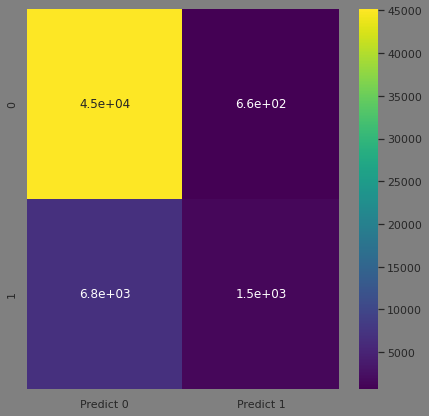

In [96]:
print('Confusion Matrix for logistic regression')

cm = metrics.confusion_matrix(y_test, xgbc_pred, labels=[0,1])

df_cm = pd.DataFrame(cm, index=[i for i in [0,1]],
                     columns=[i for i in ['Predict 0', 'Predict 1']])

plt.figure(figsize=(7,7))

sns.heatmap(df_cm, annot=True, cmap='viridis')

In [97]:
df_cm

,Predict 0,Predict 1
0,45190,655
1,6782,1473


In [98]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test, xgbc_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92     45845
           1       0.69      0.18      0.28      8255

    accuracy                           0.86     54100
   macro avg       0.78      0.58      0.60     54100
weighted avg       0.84      0.86      0.83     54100



XGB ROC AUC: 0.799


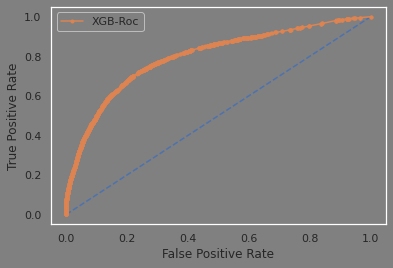

In [99]:
yhat = xgbc.predict_proba(x_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='XGB-Roc')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
print('XGB ROC AUC: %.3f' % roc_auc_score(y_test, pos_probs))
pyplot.show()

XGB PR AUC: 0.499


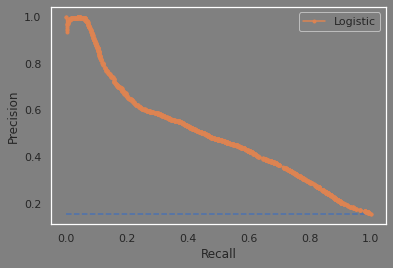

In [100]:
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('XGB PR AUC: %.3f' % auc_score)
# plot precision-recall curves
plot_pr_curve(y_test, pos_probs)

In [106]:
test_pred = xgbc.predict(test)
sub = pd.read_csv('/content/drive/MyDrive/CRedit Card Lead Prediction/test.csv')
output = pd.DataFrame({'ID': sub.ID,
                      'Is_Lead': test_pred})
output.to_csv('/content/drive/MyDrive/CRedit Card Lead Prediction/submission_xgb.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## d. ANN

In [92]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

def build_classifier(optimizer):
  ann = Sequential()

  # input and first hidden layer
  ann.add(Dense(units=18, kernel_initializer='he_uniform', activation='relu', input_dim=6))

  # regualarising
  ann.add(Dropout(rate = 0.2))

  # 2nd hidden layer
  ann.add(Dense(units=18, kernel_initializer='he_uniform', activation='relu'))
  ann.add(Dropout(rate = 0.2))

  # output layer
  ann.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

  # compiling 
  ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return ann

 
ann = KerasClassifier(build_fn = build_classifier)

parameters = {'batch_size': [100, 500],
              'epochs': [5, 10],
              'optimizer': ['adam', 'rmsprop']}

grid_search = GridSearchCV(estimator = ann,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)

grid_search = grid_search.fit(x_train, y_train, verbose = 0)

In [93]:
best_parameters = grid_search.best_params_

best_accuracy = grid_search.best_score_

In [94]:
print('Best Parameters after tuning: {}'.format(best_parameters))
print('Best Accuracy after tuning: {}'.format(best_accuracy))

Best Parameters after tuning: {'batch_size': 100, 'epochs': 10, 'optimizer': 'adam'}
Best Accuracy after tuning: 0.8505113986444857


## SVM

In [ ]:
from sklearn import svm
svmc = svm.SVC(kernel='linear') # We set a SVM classifier, the default SVM Classifier (Kernel = Radial Basis Function)
svmc.fit(x_train, y_train)

svmc_accuracies = cross_val_score(svmc, X=x_test, y=y_test, cv=10)

In [103]:
print('Accuracies" \n', svmc_accuracies)
print()
print('Mean Accuracy: ', svmc_accuracies.mean())


Accuracies" 
 [0.84750462 0.84750462 0.84750462 0.84750462 0.84750462 0.84731978
 0.84731978 0.84731978 0.84731978 0.84731978]

Mean Accuracy:  0.8474121996303141


In [ ]:
svmclf = svm.SVC()

#Hyper Parameters Set
params = {'C': [6,7,8,9,10,11,12], 
          'kernel': ['linear','rbf']}

#Making models with hyper parameters sets
svmodel = GridSearchCV(svmclf, param_grid=params, n_jobs=-1)

#Learning
svmodel.fit(x_train, y_train)

#The best hyper parameters set
print("Best Hyper Parameters:\n", svmodel.best_params_)\

svmc_accuracies = cross_val_score(svmodel, X=x_test, y=y_test, cv=10)


In [ ]:
print('Accuracies" \n', svmc_accuracies)
print()
print('Mean Accuracy: ', svmc_accuracies.mean())

In [ ]:
svm_pred = svmodel.predict(x_test)

accuracy_score(y_test, svm_pred)

In [ ]:
print('Confusion Matrix for logistic regression')

cm = metrics.confusion_matrix(y_test, svm_pred, labels=[0,1])

df_cm = pd.DataFrame(cm, index=[i for i in [0,1]],
                     columns=[i for i in ['Predict 0', 'Predict 1']])

plt.figure(figsize=(7,7))

sns.heatmap(df_cm, annot=True, cmap='viridis')

In [ ]:
df_cm

In [ ]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test, svm_pred))

In [ ]:
yhat = svmodel.predict_proba(x_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='SVM-Roc')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
print('SVM ROC AUC: %.3f' % roc_auc_score(y_test, pos_probs))
pyplot.show()

In [ ]:
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('SVM PR AUC: %.3f' % auc_score)
# plot precision-recall curves
plot_pr_curve(y_test, pos_probs)

In [ ]:
test_pred = svmodel.predict(test)
sub = pd.read_csv('/content/drive/MyDrive/CRedit Card Lead Prediction/test.csv')
output = pd.DataFrame({'ID': sub.ID,
                      'Is_Lead': test_pred})
output.to_csv('/content/drive/MyDrive/CRedit Card Lead Prediction/submission_svm.csv', index=False)